# Data Mining - What should the next Champion look like?

## Problemdefiniton
In League of Legends beeinflussen neue Champions die Spielbalance. Doch sind bestimmte Champion-Typen unterrepräsentiert? Diese Arbeit nutzt Machine Learning, um vorherzusagen, welche Champion-Eigenschaften im aktuellen Spielgewicht fehlen.

So wird sich die zentrale Frage gestellt: Welche Kombination von Champion-Eigenschaften ist im derzeitigen Spielökosystem am stärksten unterrepräsentiert und könnte als Grundlage für die Entwicklung eines neuen Champions dienen?

## Import - Datenauswahl

### Import notwendiger Bibliotheken


In [2]:
# Datenverarbeitung & Numerik
import pandas as pd  # Datenverarbeitung
import numpy as np  # Numerische Berechnungen

# Visualisierung
import matplotlib.pyplot as plt  # Basis-Visualisierung
import seaborn as sns  # Erweiterte Visualisierung
%matplotlib inline  

# Datenaufbereitung & Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder  # Skalierung & Encoding
from sklearn.model_selection import train_test_split  # Aufteilung in Trainings- & Testdaten
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Modelle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest Modelle
from sklearn.linear_model import LogisticRegression, LinearRegression  # Lineare Modelle
from sklearn.svm import SVC  # Support Vector Machine Modell
from sklearn.neural_network import MLPRegressor  # Neuronales Netz für Regression
from xgboost import XGBClassifier, XGBRegressor  # Boosted Trees Modelle

# Modellbewertung
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Klassifikationsmetriken
from sklearn.metrics import r2_score, mean_squared_error  # Regressionsmetriken

# Hyperparameter-Tuning
from sklearn.model_selection import GridSearchCV

# Explorative Datenanalyse
from ydata_profiling import ProfileReport  # Automatische EDA

# Sonstiges
import itertools  # Kombinatorik
import pickle  # Modell speichern/laden

### Datenimport

Der folgende Datensatz wurde auf der Website "Kaggle" gefunden, hat seinen Ursprung jedoch in
der Analyse- und Datenplattform MetaSRC. Diese Plattform sammelt, aggregiert und analysiert Match-Daten
um die Trends des Spiels League of Legends darzustellen.
Die Daten werden direkt aus öffentlichen Riot Games-APIs bezogen, wodurch die Statistiken
patch-basiert aktualisiert werden.

In [3]:
# Datensatz laden
df = pd.read_csv('League of Legends Champion Stats 12.1.csv', sep=';')
df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23


Der nächste Datensatz entstammt auch Kaggle, hat aber seinen Ursprung in dem "League of Legends Wiki Champion Data Module".
Da dieser Veröffentlichungsdaten beinhaltet, eignet sich dieser für Zeitreihenanalysen
Der Fokus liegt allerdings auf ersterem Datensatz, dieser dient nur als Hilfe für die Zeitreihenanalyse


In [4]:
df_basic = pd.read_csv('200125_LoL_champion_data.csv')
df_basic.head()

,Unnamed: 0,id,apiname,title,difficulty,herotype,alttype,resource,stats,rangetype,...,be,rp,skill_i,skill_q,skill_w,skill_e,skill_r,skills,fullname,nickname
0,Aatrox,266.0,Aatrox,the Darkin Blade,2,Fighter,Tank,Blood Well,"{'hp_base': 650, 'hp_lvl': 114, 'mp_base': 0, ...",Melee,...,4800,880,{1: 'Deathbringer Stance'},"{1: 'The Darkin Blade', 2: 'The Darkin Blade 3'}",{1: 'Infernal Chains'},{1: 'Umbral Dash'},{1: 'World Ender'},"{1: 'Deathbringer Stance', 2: 'The Darkin Blad...",NaN,NaN
1,Ahri,103.0,Ahri,the Nine-Tailed Fox,2,Mage,Assassin,Mana,"{'hp_base': 590, 'hp_lvl': 104, 'mp_base': 418...",Ranged,...,3150,790,{1: 'Essence Theft'},{1: 'Orb of Deception'},{1: 'Fox-Fire'},{1: 'Charm'},{1: 'Spirit Rush'},"{1: 'Essence Theft', 2: 'Orb of Deception', 3:...",NaN,NaN
2,Akali,84.0,Akali,the Rogue Assassin,2,Assassin,NaN,Energy,"{'hp_base': 600, 'hp_lvl': 119, 'mp_base': 200...",Melee,...,3150,790,"{1: ""Assassin's Mark""}",{1: 'Five Point Strike'},{1: 'Twilight Shroud'},{1: 'Shuriken Flip'},{1: 'Perfect Execution'},"{1: ""Assassin's Mark"", 2: 'Five Point Strike',...",Akali Jhomen Tethi,NaN
3,Akshan,166.0,Akshan,the Rogue Sentinel,3,Marksman,Assassin,Mana,"{'hp_base': 630, 'hp_lvl': 107, 'mp_base': 350...",Ranged,...,4800,880,{1: 'Dirty Fighting'},{1: 'Avengerang'},{1: 'Going Rogue'},{1: 'Heroic Swing'},{1: 'Comeuppance'},"{1: 'Dirty Fighting', 2: 'Avengerang', 3: 'Goi...",NaN,NaN
4,Alistar,12.0,Alistar,the Minotaur,1,Tank,Support,Mana,"{'hp_base': 685, 'hp_lvl': 120, 'mp_base': 350...",Melee,...,1350,585,{1: 'Triumphant Roar'},{1: 'Pulverize'},{1: 'Headbutt'},{1: 'Trample'},{1: 'Unbreakable Will'},"{1: 'Triumphant Roar', 2: 'Pulverize', 3: 'Hea...",NaN,NaN


### Merging

In [5]:
# Verbunden werden die Datensätze durch den gemeinsamen Schlüssel des Champion-Namens
# Dabei wollen wir zum ersten Datensatz die Informationen bezüglich Veröffenlichungsdatum hinzufügen

# Spaltennamen für Konsistenz anpassen
df_basic.rename(columns={'apiname': 'Name'}, inplace=True)

# 'date' Spalte in datetime umwandeln
df_basic['date'] = pd.to_datetime(df_basic['date'], errors='coerce')

# Füge die Veröffentlichungsdaten aus df_basic zum Haupt-Datensatz df hinzu
df = pd.merge(df, df_basic[['Name', 'date']], on='Name', how='left')

df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,date
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97,2013-06-13
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56,2011-12-14
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34,2010-05-11
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04,2010-05-11
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23,2021-07-22


## EDA und Pre-processing

Da dies ein Machine Learning Projekt ist, ist es wichtig, dass wir in den folgenden Abschnitten einen Überblick über die Daten erhalten und die Daten entsprechend vorbereiten.
Für die spätere Modellerstellung ist es dabei wichtig, dass Nullwerte entfernt werden, die Daten in numerische Werte umgewandelt werden und die Daten in Trainings- und Testdaten aufgeteilt werden.
Auch Skalierung der Daten ist wichtig, um sicherzustellen, dass die Modelle korrekt trainiert werden.
Der erste Schritt ist es, sich die Daten genauer anzuschauen, um zu sehen, welche Daten vorhanden sind und wie sie aussehen.

In [6]:
# Übersicht über die Daten
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Name    234 non-null    object        
 1   Class   233 non-null    object        
 2   Role    234 non-null    object        
 3   Tier    234 non-null    object        
 4   Score   234 non-null    float64       
 5   Trend   234 non-null    float64       
 6   Win %   234 non-null    object        
 7   Role %  234 non-null    object        
 8   Pick %  234 non-null    object        
 9   Ban %   234 non-null    object        
 10  KDA     234 non-null    float64       
 11  date    214 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 22.1+ KB


In [ ]:
# Beschreibung der numerischen Spalten
# In Anbetracht der CRISP-DM-Vorgehensweise werden bedeutsame Kennzahlen wie Mittelwert, Median und
# Standardabweichung betrachtet

print(df.describe())

            Score       Trend         KDA                           date
count  234.000000  234.000000  234.000000                            214
mean    49.953675   -0.282991    2.332863  2012-08-29 08:17:56.635514112
min     11.030000  -20.170000    1.450000            2009-02-21 00:00:00
25%     38.935000   -3.480000    2.040000            2009-10-10 00:00:00
50%     46.560000   -0.815000    2.305000            2011-05-10 00:00:00
75%     59.100000    2.060000    2.547500            2013-12-13 00:00:00
max     94.230000   44.710000    4.110000            2021-09-23 00:00:00
std     16.473484    6.418863    0.414238                            NaN


### Zeitreihenanalyse

In [8]:
# Die Datumsspalte in numerische Werte umwandeln

# Veröffentlichungsdatum extrahieren
df['release_year'] = df['date'].dt.year

# Date spalte entfernen
df.drop('date', axis=1, inplace=True)

In [9]:
# Anzahl der veröffentlichten Champions pro Jahr berechnen
release_counts = df['release_year'].value_counts().sort_index()

In [10]:
# Veröffentlichung pro Rolle und Klasse analysieren
role_counts = df.groupby(['release_year', 'Role']).size().unstack()
class_counts = df.groupby(['release_year', 'Class']).size().unstack()

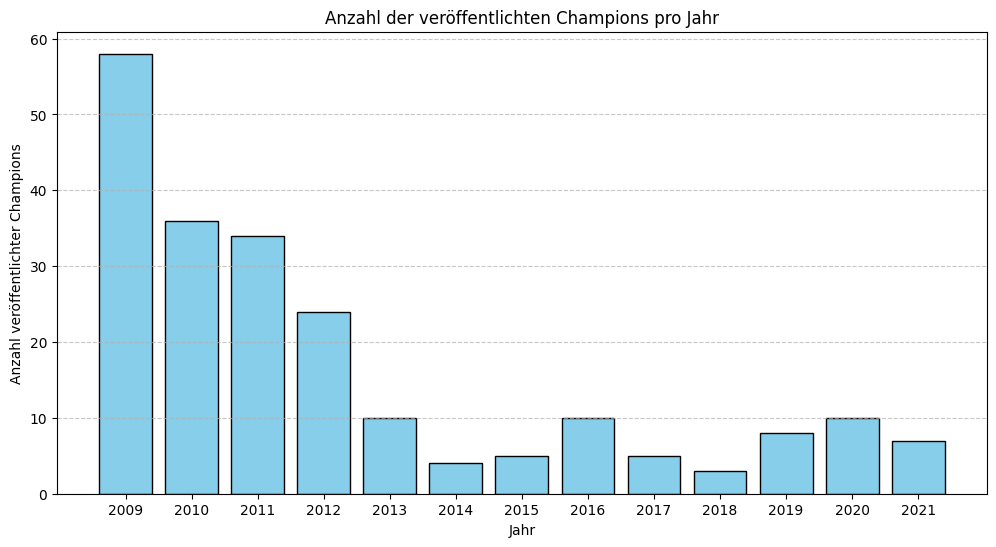

In [11]:
# Anzahl veröffentlichter Champions pro Jahr 
plt.figure(figsize=(12, 6))
plt.bar(release_counts.index, release_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Jahr")
plt.ylabel("Anzahl veröffentlichter Champions")
plt.title("Anzahl der veröffentlichten Champions pro Jahr")
plt.xticks(release_counts.index) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### In numerische Werte umwandeln

In [12]:
# Umwandlung von Prozentangaben in numerische Werte
percent_columns = ["Win %", "Role %", "Pick %", "Ban %"]
for col in percent_columns:
    df[col] = df[col].str.replace('%', '').astype(float) / 100  # Prozent in Dezimalzahl umwandeln

print(df["Pick %"].describe())

numerical_features = ['Win %', 'Pick %', 'Ban %', 'Score', 'KDA', 'release_year']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


count    234.000000
mean       0.041631
std        0.040892
min        0.001800
25%        0.012125
50%        0.029700
75%        0.057900
max        0.245500
Name: Pick %, dtype: float64


### Betrachtung fehlender Werte

In [13]:
# Fehlende Werte
print(df.isnull().sum())
df.head()

Name             0
Class            1
Role             0
Tier             0
Score            0
Trend            0
Win %            0
Role %           0
Pick %           0
Ban %            0
KDA              0
release_year    20
dtype: int64


,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,0.504696,6.52,-0.052971,0.9462,0.065415,-0.492072,-0.877856,0.233027
1,Ahri,Mage,MID,A,0.198094,-0.24,-0.076796,0.9347,0.111978,-0.620468,0.549500,-0.324155
2,Akali,Assassin,MID,S,0.933574,6.51,-0.874946,0.6565,0.979527,0.915092,0.017266,-0.602746
3,Akali,Assassin,TOP,A,0.481580,3.34,-0.886858,0.3406,0.018852,0.915092,-0.708508,-0.602746
4,Akshan,Marksman,MID,S,0.602030,0.65,0.834524,0.5801,0.163443,2.086216,-0.248852,2.461753


### Weitere EDA-Visualisierungen

<Figure size 1200x600 with 0 Axes>

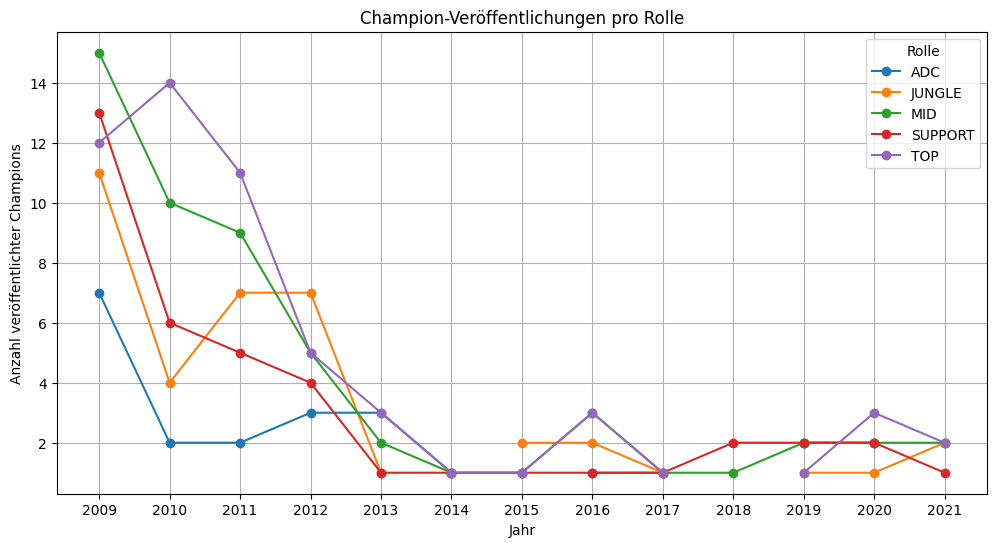

In [14]:
# Veröffentlichungen nach Rolle
plt.figure(figsize=(12, 6))
role_counts.plot(kind='line', marker='o', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("Anzahl veröffentlichter Champions")
plt.title("Champion-Veröffentlichungen pro Rolle")
plt.xticks(release_counts.index)
plt.legend(title="Rolle")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

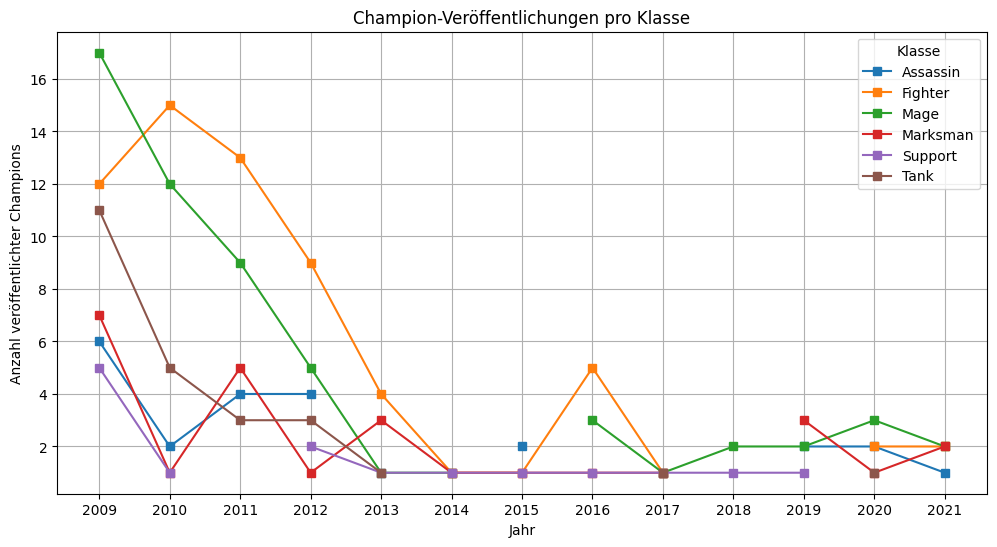

In [15]:
# Veröffentlichungen nach Klasse
plt.figure(figsize=(12, 6))
class_counts.plot(kind='line', marker='s', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("Anzahl veröffentlichter Champions")
plt.title("Champion-Veröffentlichungen pro Klasse")
plt.xticks(release_counts.index)
plt.legend(title="Klasse")
plt.grid(True)
plt.show()

c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

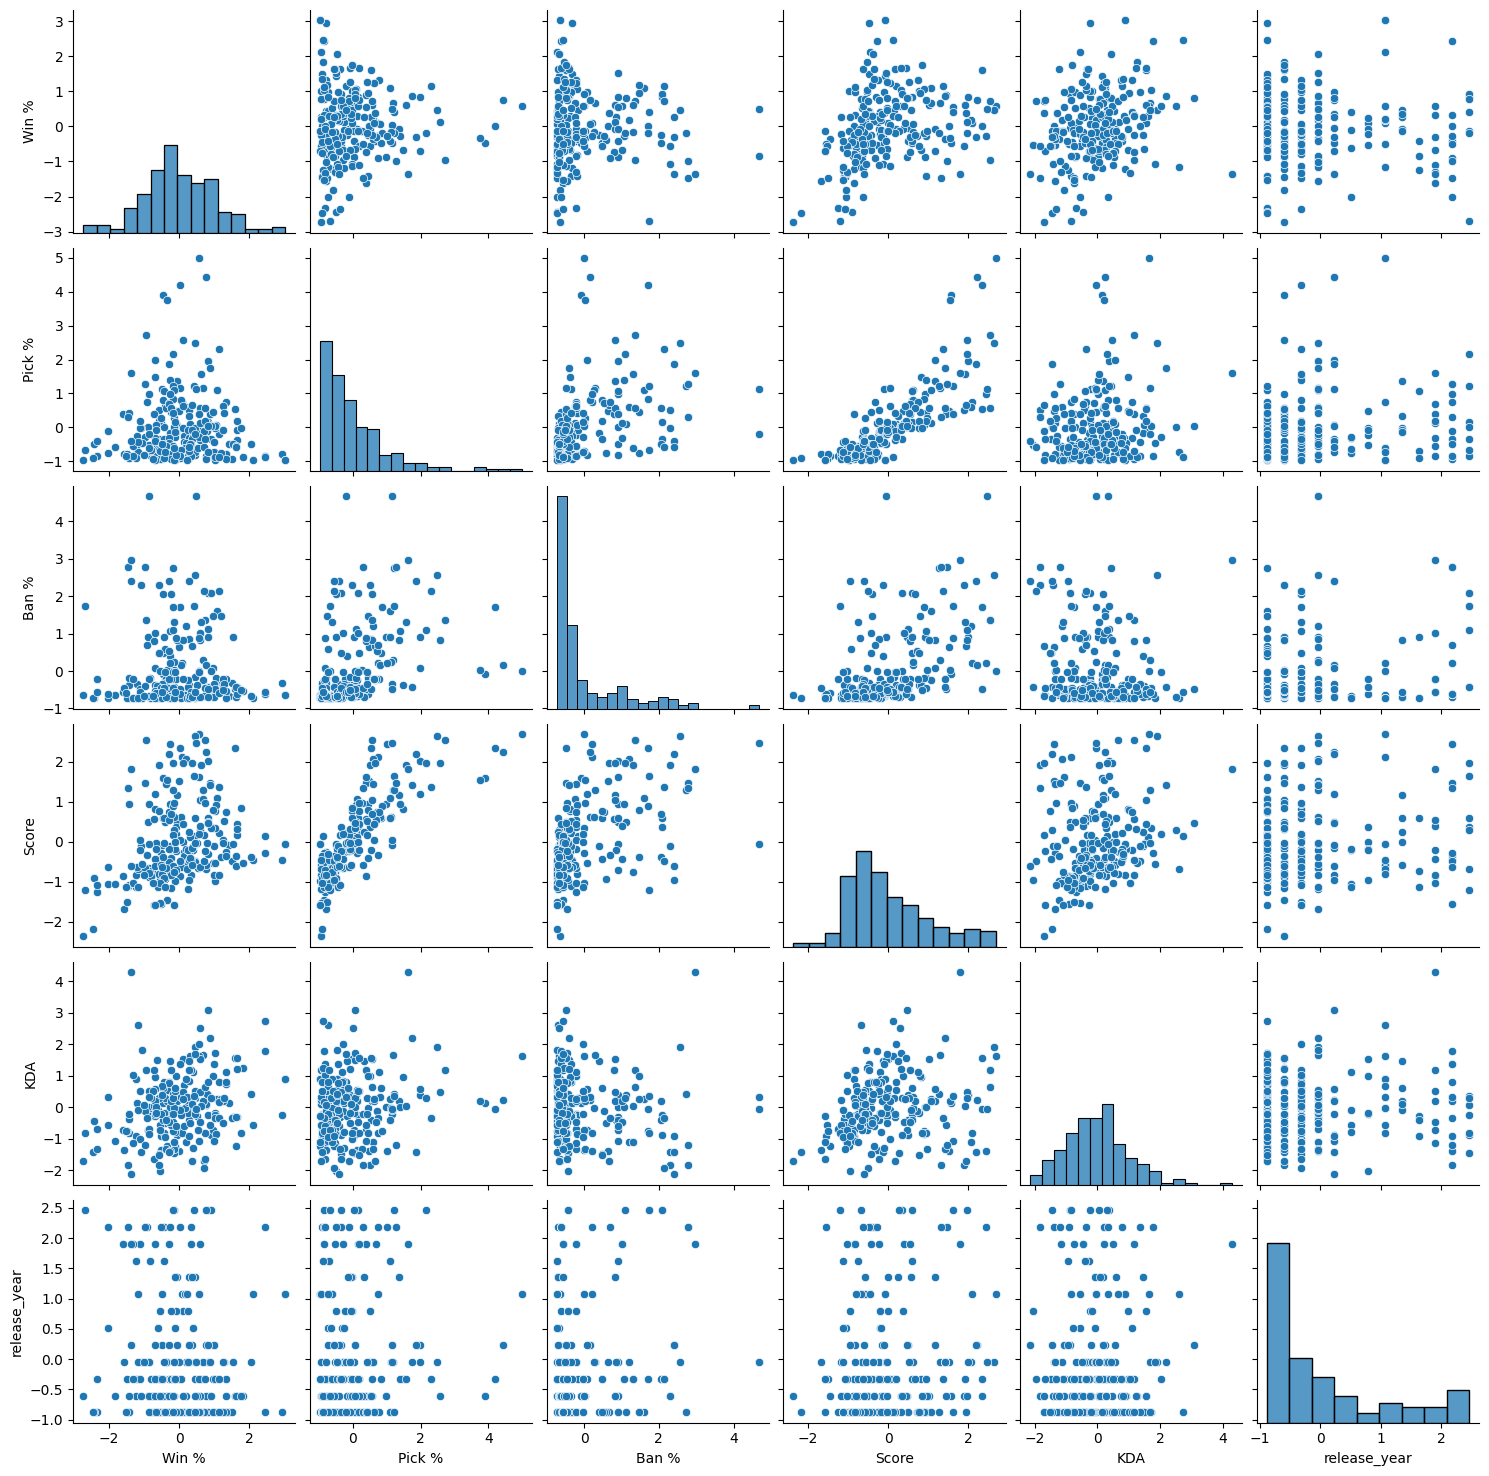

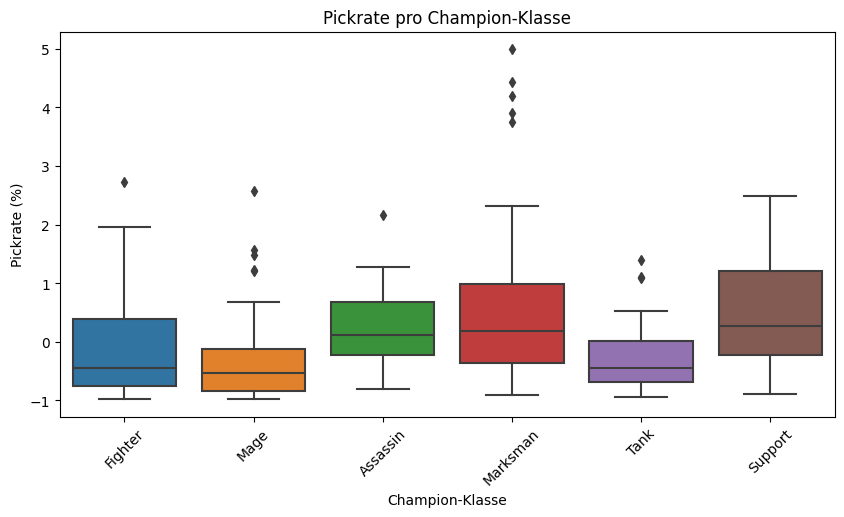

In [16]:
# Pairplot zur Visualisierung der Feature-Zusammenhänge
sns.pairplot(df[numerical_features])
# Boxplot der Pickrate pro Klasse
plt.figure(figsize=(10, 5))
sns.boxplot(x='Class', y='Pick %', data=df)
plt.xlabel('Champion-Klasse')
plt.ylabel('Pickrate (%)')
plt.title('Pickrate pro Champion-Klasse')
plt.xticks(rotation=45)
plt.show()

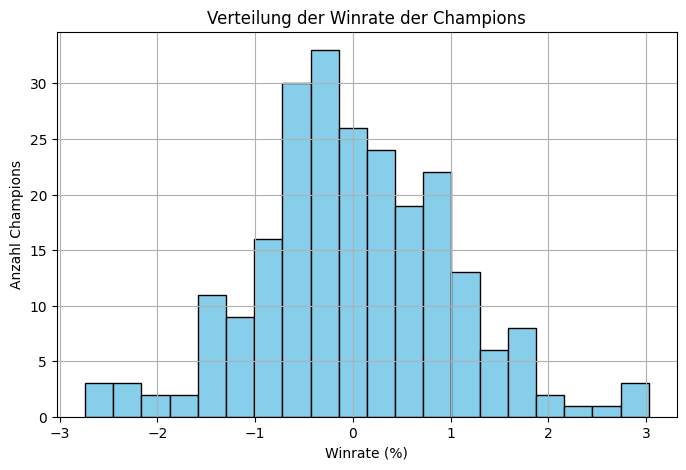

In [ ]:
# Histogramm der Winrate
plt.figure(figsize=(8,5))
df['Win %'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Verteilung der Winrate der Champions')
plt.xlabel('Winrate (%)')
plt.ylabel('Anzahl Champions')
plt.show()

### Ydata Profiling Report erstellen

In [ ]:
# Für den ydata_profiling Report entfernen wir nicht float Datentypen wie 'Name'
df_profile_report = df.drop(['Name'], axis=1)
df_profile_report.head() 

# Ydata Profiling Report erstellen
profile = ProfileReport(df, explorative=True)
profile.to_widgets()  

# den Profile Report als HTML-Datei speichern
profile.to_file("ydata_profiling_report.html")